In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
n_samples=1000

X,y = make_circles(n_samples, noise=0.03, random_state=42)
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [3]:
#Make Dataframe of circles

import pandas as pd

circles=pd.DataFrame({"X1": X[:,0],
                      "X2": X[:,1],
                      "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


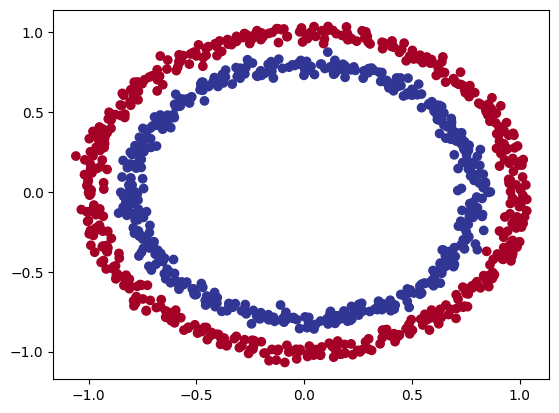

In [4]:
#visualize
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

### Checking imput and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
X_sample= X[0]
y_sample= y[0]

X_sample, y_sample,X_sample.shape

(array([0.75424625, 0.23148074]), np.int64(1), (2,))

In [7]:
# Turn the data into tensors
import torch

X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [8]:
#split the data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2,random_state=42)

len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [9]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

### Building the model

Lets build a model ton classify our blue and red dots

To do so,
1. Setup device agonistic code
2. Construct a model
3. Define a loss function and optimizer
4. Create a training and test loop

In [10]:
# 1. device setup
from torch import nn

device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
# 2. Create a model

class CircleModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1=nn.Linear(in_features=2,out_features=5) # takes 2 in features and upscales in 5 features
        self.layer2=nn.Linear(in_features=5,out_features=1) # takes in 5 features and outputs 1 layer

        # self.layers=nn.Sequential(
        #     nn.Linear(in_features=2,out_features=5),
        #     nn.Linear(in_features=5,out_features=1)
        # )
    
    def forward(self, x):
        return self.layer2(self.layer1(x))

model_0=CircleModel().to(device)
model_0

CircleModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [13]:
model_0=nn.Sequential(
            nn.Linear(in_features=2,out_features=5),
            nn.Linear(in_features=5,out_features=1)
        ).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Make prediction
with torch.inference_mode():
    
    untrained_preds=model_0(X_test.to(device))

untrained_preds[:10]

tensor([[-0.4746],
        [-0.6268],
        [-0.2184],
        [-0.5466],
        [-0.4453],
        [-0.5365],
        [-0.7854],
        [-0.7648],
        [-0.2092],
        [-0.6395]], device='cuda:0')

In [15]:
# setup loss function

loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [16]:
#Calculate accuracy

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc= (correct/len(y_pred))*100
    return acc

In [17]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

### Making logits. 
### Because we used `BCEWithLogitsLoss()`

In [18]:
#logits. they are the raw data comes from direct model without passing on any layer
model_0.eval()

with torch.inference_mode():
    y_logit=model_0(X_test.to(device))

y_logit[:10]

tensor([[-0.4746],
        [-0.6268],
        [-0.2184],
        [-0.5466],
        [-0.4453],
        [-0.5365],
        [-0.7854],
        [-0.7648],
        [-0.2092],
        [-0.6395]], device='cuda:0')

In [19]:
y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

In [20]:
# Use sigmoid activation to turn them into prediction probabilities

y_pred_probs= torch.sigmoid(y_logit)
y_pred_probs[:10]

tensor([[0.3835],
        [0.3482],
        [0.4456],
        [0.3667],
        [0.3905],
        [0.3690],
        [0.3132],
        [0.3176],
        [0.4479],
        [0.3453]], device='cuda:0')

In [21]:
#Find the predicted label
y_preds=torch.round(y_pred_probs)[:5]

#In Full
y_pred_label=torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#check equality
print(torch.eq(y_preds.squeeze(),y_pred_label.squeeze()))

#get rid of extra dimesions
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

### Building training and testing loop


In [22]:
# Training 

torch.manual_seed(42)

epochs=100

X_train,y_train= X_train.to(device),y_train.to(device)
X_test,y_test= X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    # 1. Forward pass
    y_logits=model_0(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))

    #2. Calculate the loss/ Accuracy
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_train,y_pred)

    #3. optimize zero grade
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. optimizer step
    optimizer.step()

    # Testing loop
    model_0.eval()
    with torch.inference_mode():
        y_test_logits=model_0(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(y_test_logits))

        test_loss=loss_fn(y_test_logits,y_test)
        test_acc=accuracy_fn(y_test,test_pred)
    
    if epoch % 10 ==0:
        print(f"|Epochs : {epoch} | Loss : {loss:.4f}  Train_Acc: {acc:.2f}% | Test_loss : {test_loss:.4f}  Test_Acc : {test_acc:.2f}% | ")

|Epochs : 0 | Loss : 0.7255  Train_Acc: 50.00% | Test_loss : 0.7175  Test_Acc : 50.00% | 
|Epochs : 10 | Loss : 0.7098  Train_Acc: 50.00% | Test_loss : 0.7034  Test_Acc : 50.00% | 
|Epochs : 20 | Loss : 0.7026  Train_Acc: 40.75% | Test_loss : 0.6973  Test_Acc : 43.50% | 
|Epochs : 30 | Loss : 0.6990  Train_Acc: 45.38% | Test_loss : 0.6945  Test_Acc : 51.00% | 
|Epochs : 40 | Loss : 0.6972  Train_Acc: 46.88% | Test_loss : 0.6933  Test_Acc : 51.00% | 
|Epochs : 50 | Loss : 0.6961  Train_Acc: 47.88% | Test_loss : 0.6928  Test_Acc : 51.00% | 
|Epochs : 60 | Loss : 0.6954  Train_Acc: 48.25% | Test_loss : 0.6926  Test_Acc : 49.50% | 
|Epochs : 70 | Loss : 0.6949  Train_Acc: 48.75% | Test_loss : 0.6925  Test_Acc : 49.50% | 
|Epochs : 80 | Loss : 0.6945  Train_Acc: 48.88% | Test_loss : 0.6926  Test_Acc : 48.50% | 
|Epochs : 90 | Loss : 0.6943  Train_Acc: 49.25% | Test_loss : 0.6926  Test_Acc : 50.00% | 


### Make prediction and evaluate the model

From the metric, it seems like our model is not learning
So, to inspect, lets make some prediction and make them visualize
To do so, we're going to import a function called `plot_decision_boundary`

In [23]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print("It already exists")

else:
    print('Downloading')
    request= requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')

    with open("helper_functions.py",'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

It already exists


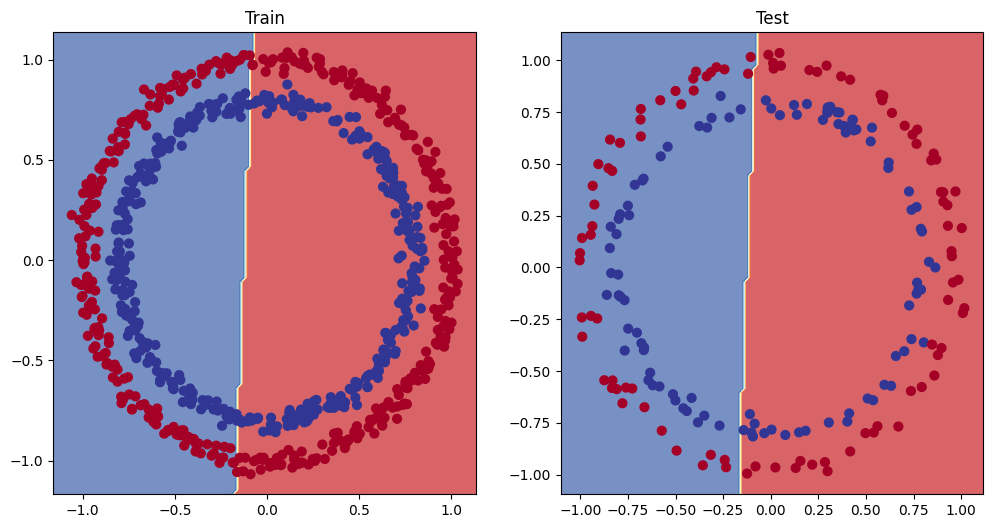

In [24]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test,y_test)

## Improving a model From a model perspective
* Add more layers
* Add more hidden units - go from 5 hidden units to 10
* Fit for longer- epochs many
* Changing activation function
* Change the learning rate
* Change the loss function

In [25]:
class CircleModelV1(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers_1= nn.Linear(in_features=2, out_features=10)
        self.layers_2=nn.Linear(in_features=10,out_features=10)
        self.layers_3=nn.Linear(in_features=10,out_features=1)
    
    def forward(self,x):
        return self.layers_3(self.layers_2(self.layers_1(x)))

model_1= CircleModelV1().to(device)

In [26]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
model_1

CircleModelV1(
  (layers_1): Linear(in_features=2, out_features=10, bias=True)
  (layers_2): Linear(in_features=10, out_features=10, bias=True)
  (layers_3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
model_1.state_dict()

OrderedDict([('layers_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layers_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layers_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.

In [29]:
# Create a loss Function
loss_fn1=nn.BCEWithLogitsLoss()

#Create optimizer
optimizer1= torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [30]:
# Write a training and evaluation loop
torch.manual_seed
torch.cuda.manual_seed(42)

X_train,y_train= X_train.to(device),y_train.to(device)
X_test,y_test= X_test.to(device),y_test.to(device)

#train for longer
epochs=1000

for epoch in range(epochs):
    ### Training ###
    model_1.train()

    #1. forward the pass
    y_logits1=model_1(X_train).squeeze()
    y_pred1=torch.round(torch.sigmoid(y_logits1))

    #2. Calculate the loss/acc
    loss1=loss_fn1(y_logits1,y_train)
    acc1=accuracy_fn(y_train,y_pred1)

    #3. optimizer zero grad
    optimizer1.zero_grad()

    #4. loss backward
    loss1.backward()

    #5. optimizer step
    optimizer1.step()

    ### Testing ### 
    
    model_1.eval()
    with torch.inference_mode():
        #1.
         y_test_logits1=model_1(X_test).squeeze()
         y_test_pred1=torch.round(torch.sigmoid(y_test_logits1))
        #2.
         test_loss1=loss_fn1(y_test_logits1,y_test)
         test_acc1=accuracy_fn(y_test,y_test_pred1)
   
    if epoch % 100 ==0:
        print(f"|Epochs : {epoch} | Loss : {loss1:.4f}  Train_Acc: {acc1:.2f}% | Test_loss : {test_loss1:.4f}  Test_Acc : {test_acc1:.2f}% | ")


|Epochs : 0 | Loss : 0.6940  Train_Acc: 50.88% | Test_loss : 0.6926  Test_Acc : 51.00% | 
|Epochs : 100 | Loss : 0.6930  Train_Acc: 50.38% | Test_loss : 0.6938  Test_Acc : 48.00% | 
|Epochs : 200 | Loss : 0.6930  Train_Acc: 51.12% | Test_loss : 0.6944  Test_Acc : 46.00% | 
|Epochs : 300 | Loss : 0.6930  Train_Acc: 51.62% | Test_loss : 0.6946  Test_Acc : 45.00% | 
|Epochs : 400 | Loss : 0.6930  Train_Acc: 51.12% | Test_loss : 0.6946  Test_Acc : 46.00% | 
|Epochs : 500 | Loss : 0.6930  Train_Acc: 51.00% | Test_loss : 0.6947  Test_Acc : 46.00% | 
|Epochs : 600 | Loss : 0.6930  Train_Acc: 51.00% | Test_loss : 0.6947  Test_Acc : 46.00% | 
|Epochs : 700 | Loss : 0.6930  Train_Acc: 51.00% | Test_loss : 0.6947  Test_Acc : 46.00% | 
|Epochs : 800 | Loss : 0.6930  Train_Acc: 51.00% | Test_loss : 0.6947  Test_Acc : 46.00% | 
|Epochs : 900 | Loss : 0.6930  Train_Acc: 51.00% | Test_loss : 0.6947  Test_Acc : 46.00% | 


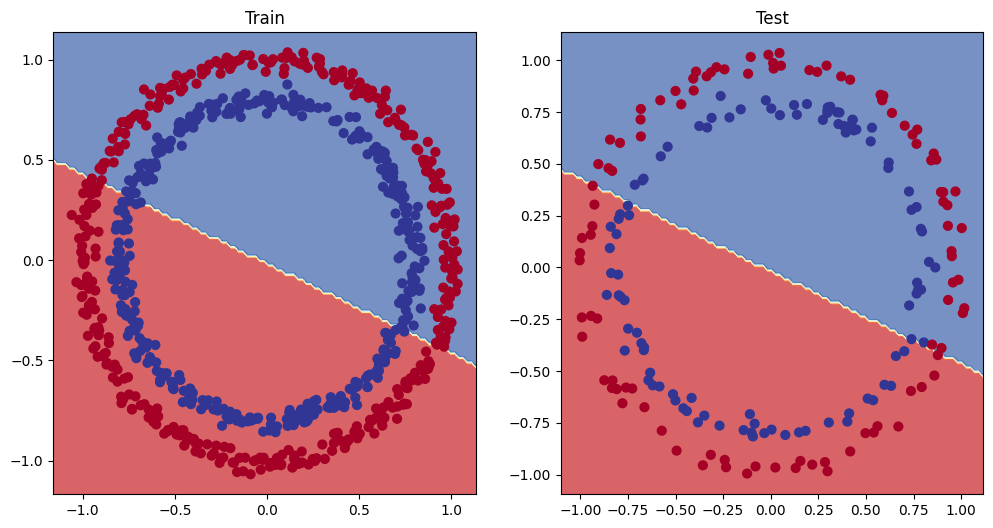

In [31]:
#Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test,y_test)

### Preparing our data to see if our model can fit a straight line

one way to trouble shoot is to test out a smaller problem

In [32]:
# Create some data 
weight=.7
bias= .3
start=0
end=1
step=0.01

# Create data
X_regression= torch.arange(start,end,step).unsqueeze(dim=1)
y_regression= weight*X_regression + bias

#Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [33]:
# Create train and test split
train_split= int(0.8* len(X_regression))


X_train_regression, y_train_regession= X_regression[:train_split], y_regression[:train_split]

X_test_regression,y_test_regression=X_regression[train_split:], y_regression[train_split:]

len(X_train_regression),len(y_train_regession)

(80, 80)

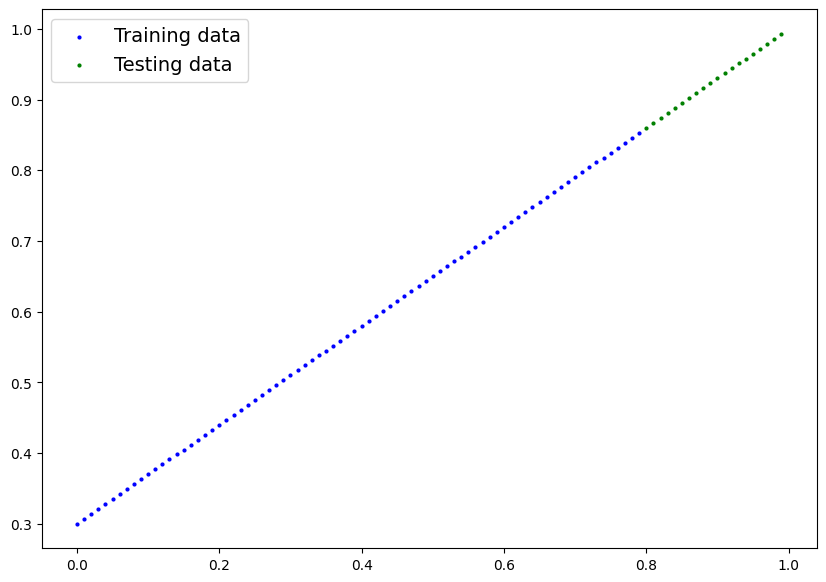

In [34]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regession,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [35]:
model_1

CircleModelV1(
  (layers_1): Linear(in_features=2, out_features=10, bias=True)
  (layers_2): Linear(in_features=10, out_features=10, bias=True)
  (layers_3): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
model_2=nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

In [37]:
loss_fn2= nn.L1Loss()
optimizer2=torch.optim.SGD(params=model_2.parameters(),lr=0.01)

In [38]:
# TRAIN THE MODEL
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train_regression,y_train_regession= X_train_regression.to(device),y_train_regession.to(device)
X_test_regression,y_test_regression= X_test_regression.to(device),y_test_regression.to(device)

### Train ###
for epoch in range(epochs):
    
    y_pred2=model_2(X_train_regression)
    loss2=loss_fn2(y_train_regession,y_pred2)
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()

    ### Test ###
    model_2.eval()
    with torch.inference_mode():
        y_test_pred2=model_2(X_test_regression)
        test_loss2=loss_fn2(y_test_regression,y_test_pred2)

    if epoch % 100 == 0:
        print(f"|Epochs : {epoch} | Loss : {loss2:.5f}| Test_loss : {test_loss2:.5f}| ")



|Epochs : 0 | Loss : 0.57896| Test_loss : 0.82273| 
|Epochs : 100 | Loss : 0.03496| Test_loss : 0.00156| 
|Epochs : 200 | Loss : 0.03268| Test_loss : 0.00330| 
|Epochs : 300 | Loss : 0.02942| Test_loss : 0.00446| 
|Epochs : 400 | Loss : 0.02731| Test_loss : 0.00570| 
|Epochs : 500 | Loss : 0.02671| Test_loss : 0.00534| 
|Epochs : 600 | Loss : 0.02627| Test_loss : 0.00511| 
|Epochs : 700 | Loss : 0.02594| Test_loss : 0.00496| 
|Epochs : 800 | Loss : 0.02482| Test_loss : 0.00394| 
|Epochs : 900 | Loss : 0.02333| Test_loss : 0.00462| 


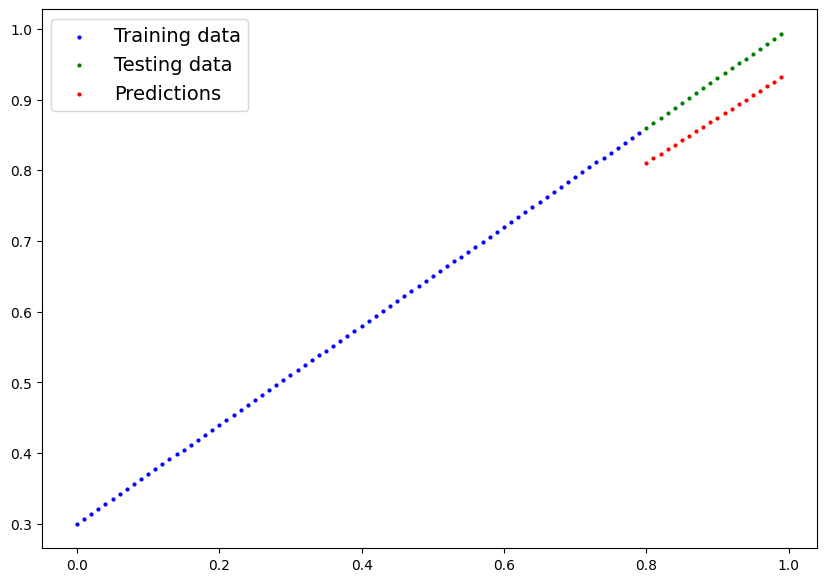

In [39]:
model_2.eval()
with torch.inference_mode():
    y_preds= model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regession.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

### Introducing non-linearity

In [40]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

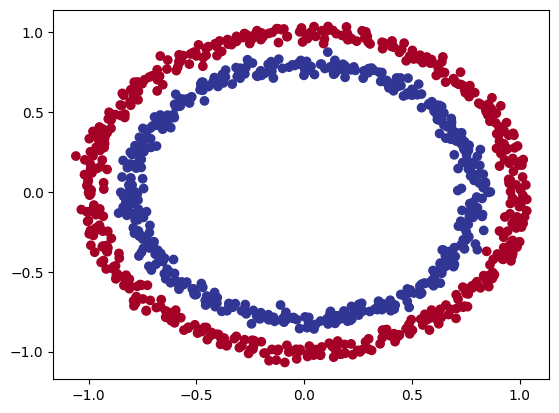

In [41]:
n_samples=1000

X,y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [42]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# turn the data into tensor
X= torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

# split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

X_train[:5],y_train[:5],X_test[:5],y_test[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438]]),
 tensor([1., 0., 1., 0., 1.]))

In [43]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.layer_1=nn.Linear(in_features=2,out_features=10)
        self.layer_2=nn.Linear(in_features=10,out_features=10)
        self.layer_3=nn.Linear(in_features=10,out_features=1)
        self.relu=nn.ReLU()
        
    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3=CircleModelV2().to(device)


In [44]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_3.parameters(),lr=0.1)

In [45]:
### Train ##
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

device= "cuda" if torch.cuda.is_available() else "cpu"
X_train, y_train =X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    ### Tarining ###

    model_3.train()

    y_logits=model_3(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_train,y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing ###
    model_3.eval()

    with torch.inference_mode():
        y_test_logits=model_3(X_test).squeeze()
        y_test_pred=torch.round(torch.sigmoid(y_test_logits))

        test_loss=loss_fn(y_test_logits,y_test)
        test_acc=accuracy_fn(y_test,y_test_pred)

    if epoch % 100 ==0:
        print(f"|Epochs : {epoch} | Loss : {loss:.4f}  Train_Acc: {acc:.2f}% | Test_loss : {test_loss:.4f}  Test_Acc : {test_acc:.2f}% | ")
        

|Epochs : 0 | Loss : 0.6929  Train_Acc: 50.00% | Test_loss : 0.6932  Test_Acc : 50.00% | 
|Epochs : 100 | Loss : 0.6912  Train_Acc: 52.88% | Test_loss : 0.6910  Test_Acc : 52.50% | 
|Epochs : 200 | Loss : 0.6898  Train_Acc: 53.37% | Test_loss : 0.6894  Test_Acc : 55.00% | 
|Epochs : 300 | Loss : 0.6879  Train_Acc: 53.00% | Test_loss : 0.6872  Test_Acc : 56.00% | 
|Epochs : 400 | Loss : 0.6852  Train_Acc: 52.75% | Test_loss : 0.6841  Test_Acc : 56.50% | 
|Epochs : 500 | Loss : 0.6810  Train_Acc: 52.75% | Test_loss : 0.6794  Test_Acc : 56.50% | 
|Epochs : 600 | Loss : 0.6751  Train_Acc: 54.50% | Test_loss : 0.6729  Test_Acc : 56.00% | 
|Epochs : 700 | Loss : 0.6666  Train_Acc: 58.38% | Test_loss : 0.6632  Test_Acc : 59.00% | 
|Epochs : 800 | Loss : 0.6516  Train_Acc: 64.00% | Test_loss : 0.6476  Test_Acc : 67.50% | 
|Epochs : 900 | Loss : 0.6236  Train_Acc: 74.00% | Test_loss : 0.6215  Test_Acc : 79.00% | 


In [46]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds=torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds

y_preds==y_test

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True, False,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True, False, False,  True,  True,  True, 

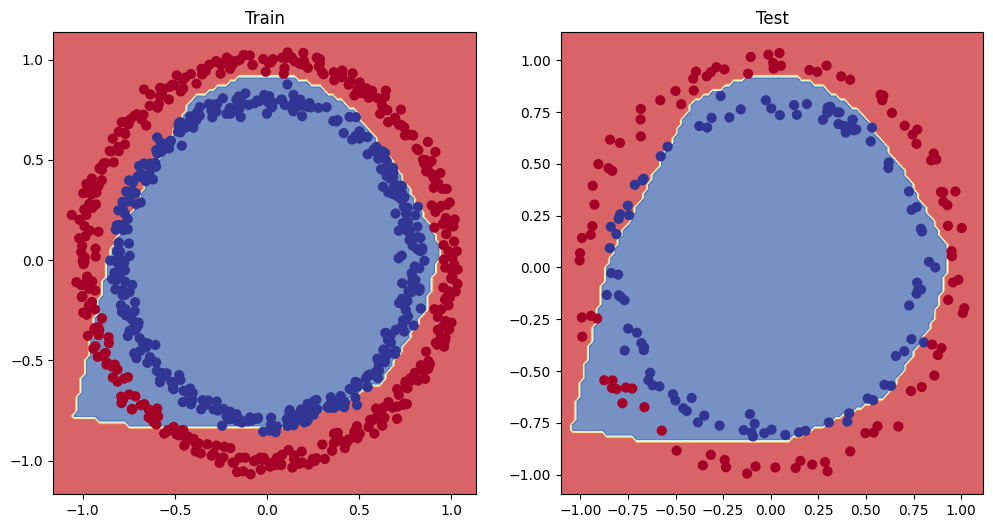

In [47]:
#Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3, X_test,y_test)

### Replicating non_linear activation functions

In [48]:
# Create a tensor
A= torch.arange(-10,10,1)

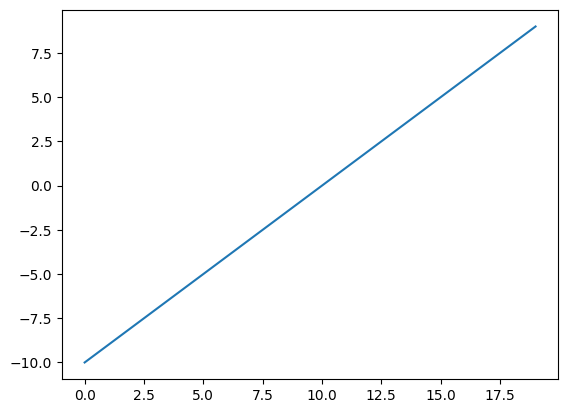

In [49]:
#Visualize
plt.plot(A)

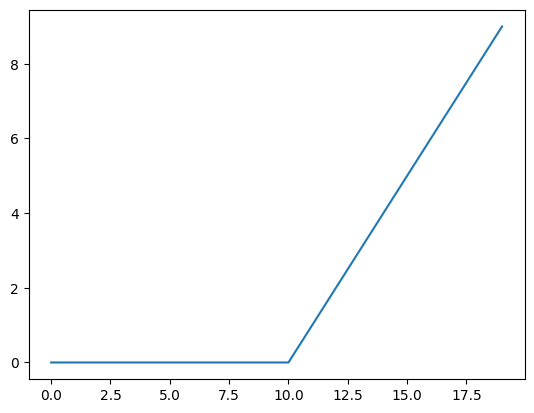

In [50]:
plt.plot(torch.relu(A))

### Creating a toy  Multiclass dataset

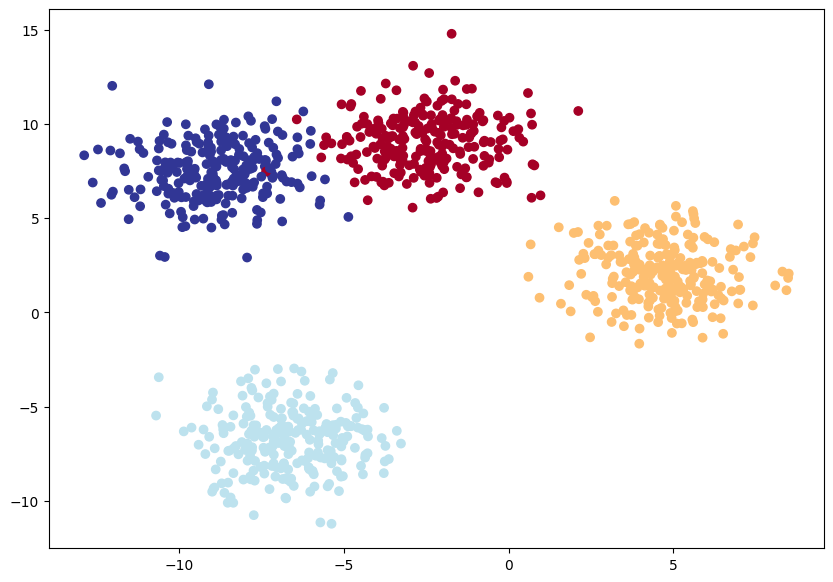

In [51]:
import torch
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

num_classes=4
num_features=2
random_seed=42

#1. create muti_class data
X_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=num_features,
                         centers=num_classes,
                         cluster_std=1.5,
                         random_state=random_seed)

#2. Turn data into tensors
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

#3.split
split= X_train,X_test,y_train,y_test=train_test_split(X_blob,
                                                      y_blob,test_size=.2,
                                                      random_state=42)

#4. plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### Building a multiclass classification model

In [52]:
device="cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# building the model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer=nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features),           
        )
    
    def forward(self,x):
        return self.linear_layer(x)

model_4= BlobModel(2,4).to(device)        

In [54]:
X_train.shape, torch.unique(y_train)

(torch.Size([800, 2]), tensor([0, 1, 2, 3]))

### Creating the loss function and optimizer

In [55]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model_4.parameters(),lr=0.1)

In [56]:
X_test=X_test.to(device)

model_4.eval()
with torch.inference_mode():
    y_logits=model_4(X_test)

y_logits[:10]

tensor([[-0.3782, -0.0598,  0.2240,  0.1938],
        [-0.3166, -0.1224,  0.1877,  0.2034],
        [-0.3124, -0.2372,  0.2952,  0.2379],
        [-0.3386, -0.0803,  0.2329,  0.1795],
        [-0.3224, -0.0751,  0.2386,  0.1718],
        [-0.3203, -0.1184,  0.1726,  0.2133],
        [-0.3238, -0.2145,  0.2744,  0.2181],
        [-0.3122, -0.0881,  0.2237,  0.1789],
        [-0.3079, -0.2326,  0.2916,  0.2358],
        [-0.3106, -0.0812,  0.2342,  0.1718]], device='cuda:0')

In [57]:
# Convert our model logit outouts to LOGIT to prediction probabilities
y_pred_probs=torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.3782, -0.0598,  0.2240,  0.1938],
        [-0.3166, -0.1224,  0.1877,  0.2034],
        [-0.3124, -0.2372,  0.2952,  0.2379],
        [-0.3386, -0.0803,  0.2329,  0.1795],
        [-0.3224, -0.0751,  0.2386,  0.1718]], device='cuda:0')
tensor([[0.1674, 0.2302, 0.3057, 0.2967],
        [0.1801, 0.2187, 0.2982, 0.3029],
        [0.1771, 0.1909, 0.3251, 0.3070],
        [0.1741, 0.2254, 0.3083, 0.2923],
        [0.1763, 0.2258, 0.3089, 0.2890]], device='cuda:0')


In [58]:
# Convert them to prediction labels
y_preds=torch.argmax(y_pred_probs, dim=1) # retirns the index 
y_preds, y_test

(tensor([2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2,
         2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2,
         2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 3,
         3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3,
         2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
         2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2,
         2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2,
         2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 3, 2, 2, 3, 2, 2, 2], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
         2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
         0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
         3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 

### Training and testing loop

In [59]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
epochs=1000

X_train, y_train= X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits=model_4(X_train)
    y_preds=torch.softmax(y_logits,dim=1).argmax(dim=1)

    loss= loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_train,y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ## Testing ##
    model_4.eval()

    with torch.inference_mode():
        y_test_logits=model_4(X_test)
        y_test_pred=torch.softmax(y_test_logits,dim=1).argmax(dim=1)

        test_loss=loss_fn(y_test_logits,y_test)
        test_acc=accuracy_fn(y_test,y_test_pred)
    if epoch % 10 ==0:
        print(f"|Epochs : {epoch} | Loss : {loss:.4f}  Train_Acc: {acc:.2f}% | Test_loss : {test_loss:.4f}  Test_Acc : {test_acc:.2f}% | ")
        

|Epochs : 0 | Loss : 1.3828  Train_Acc: 47.50% | Test_loss : 1.3525  Test_Acc : 55.00% | 
|Epochs : 10 | Loss : 1.1864  Train_Acc: 65.12% | Test_loss : 1.1432  Test_Acc : 69.50% | 
|Epochs : 20 | Loss : 0.7616  Train_Acc: 95.25% | Test_loss : 0.7508  Test_Acc : 97.00% | 
|Epochs : 30 | Loss : 0.5203  Train_Acc: 97.38% | Test_loss : 0.5378  Test_Acc : 98.50% | 
|Epochs : 40 | Loss : 0.4827  Train_Acc: 82.75% | Test_loss : 0.4679  Test_Acc : 88.50% | 
|Epochs : 50 | Loss : 0.2696  Train_Acc: 96.75% | Test_loss : 0.2750  Test_Acc : 98.50% | 
|Epochs : 60 | Loss : 0.1936  Train_Acc: 99.00% | Test_loss : 0.1908  Test_Acc : 99.50% | 
|Epochs : 70 | Loss : 0.1568  Train_Acc: 99.25% | Test_loss : 0.1525  Test_Acc : 99.50% | 
|Epochs : 80 | Loss : 0.1317  Train_Acc: 99.25% | Test_loss : 0.1268  Test_Acc : 99.50% | 
|Epochs : 90 | Loss : 0.1127  Train_Acc: 99.25% | Test_loss : 0.1072  Test_Acc : 99.50% | 
|Epochs : 100 | Loss : 0.0979  Train_Acc: 99.12% | Test_loss : 0.0913  Test_Acc : 99.50% | 

In [60]:
# Make the predictions
model_4.eval()
with torch.inference_mode():
    y_logits= model_4(X_test)

y_logits[:10]

tensor([[  3.8294,  16.7035, -10.3399, -10.4004],
        [  3.0974, -11.9727,  -1.2053,   9.3647],
        [ -1.8378,  -2.4511,   5.6667,  -1.0902],
        [ -0.7734,  11.5380,  -4.6125,  -6.9588],
        [ 14.7843,   4.3934, -12.6433,  -4.7566],
        [  3.0134, -14.0186,  -1.3842,  11.4311],
        [ -1.6082,  -1.9811,   5.1062,  -1.2126],
        [ 11.7476,  -1.8366,  -8.5220,  -0.4504],
        [ -2.0711,  -3.1463,   6.3599,  -0.8799],
        [ 12.6375,   0.3227,  -9.7592,  -1.9581]], device='cuda:0')

In [61]:
## Go from logits --> prediction probabilities
y_pred_probs= torch.softmax(y_logits,dim=1)
y_pred_probs[:10], y_test [:10]

(tensor([[2.5636e-06, 1.0000e+00, 1.7996e-12, 1.6941e-12],
         [1.8938e-03, 5.4007e-10, 2.5626e-05, 9.9808e-01],
         [5.4947e-04, 2.9758e-04, 9.9799e-01, 1.1605e-03],
         [4.4998e-06, 1.0000e+00, 9.6812e-08, 9.2667e-09],
         [9.9997e-01, 3.0712e-05, 1.2256e-12, 3.2620e-09],
         [2.2088e-04, 8.8565e-12, 2.7184e-06, 9.9978e-01],
         [1.2087e-03, 8.3246e-04, 9.9616e-01, 1.7952e-03],
         [9.9999e-01, 1.2603e-06, 1.5741e-09, 5.0409e-06],
         [2.1779e-04, 7.4315e-05, 9.9899e-01, 7.1679e-04],
         [1.0000e+00, 4.4849e-06, 1.8761e-10, 4.5837e-07]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

In [62]:
y_preds=torch.argmax(y_pred_probs,dim=1)
print(y_preds[:10])

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')


InductorError: CppCompileError: C++ compile error

Command:
cl /I c:/Users/Shanto/AppData/Local/Programs/Python/Python313/Include /I c:/Users/Shanto/AppData/Local/Programs/Python/Python313/Lib/site-packages/torch/include /I c:/Users/Shanto/AppData/Local/Programs/Python/Python313/Lib/site-packages/torch/include/torch/csrc/api/include /D TORCH_INDUCTOR_CPP_WRAPPER /D STANDALONE_TORCH_HEADER /D C10_USING_CUSTOM_GENERATED_MACROS /DLL /MD /O2 /std:c++20 /wd4819 /wd4251 /wd4244 /wd4267 /wd4275 /wd4018 /wd4190 /wd4624 /wd4067 /wd4068 /EHsc /openmp /openmp:experimental C:/Users/Shanto/AppData/Local/Temp/torchinductor_Shanto/op/cope3kiufwimepcz6xgp6egah3dytngjrq6on3wbsl4b74tq3fnu.cpp /LD /FeC:/Users/Shanto/AppData/Local/Temp/torchinductor_Shanto/op/cope3kiufwimepcz6xgp6egah3dytngjrq6on3wbsl4b74tq3fnu.pyd /link /LIBPATH:c:/Users/Shanto/AppData/Local/Programs/Python/Python313/libs /LIBPATH:c:/Users/Shanto/AppData/Local/Programs/Python/Python313/Lib/site-packages/torch/lib torch.lib torch_cpu.lib torch_python.lib sleef.lib

Output:
Microsoft (R) C/C++ Optimizing Compiler Version 19.44.35208 for x64
Copyright (C) Microsoft Corporation.  All rights reserved.

cl : Command line warning D9025 : overriding '/openmp' with '/openmp:experimental'
cope3kiufwimepcz6xgp6egah3dytngjrq6on3wbsl4b74tq3fnu.cpp
C:/Users/Shanto/AppData/Local/Temp/torchinductor_Shanto/pi/cpicxudqmdsjh5cm4klbtbrvy2cxwr7whxl3md2zzdjdf3orvfdf.h(3): fatal error C1083: Cannot open include file: 'algorithm': No such file or directory


Set TORCHDYNAMO_VERBOSE=1 for the internal stack trace (please do this especially if you're reporting a bug to PyTorch). For even more developer context, set TORCH_LOGS="+dynamo"


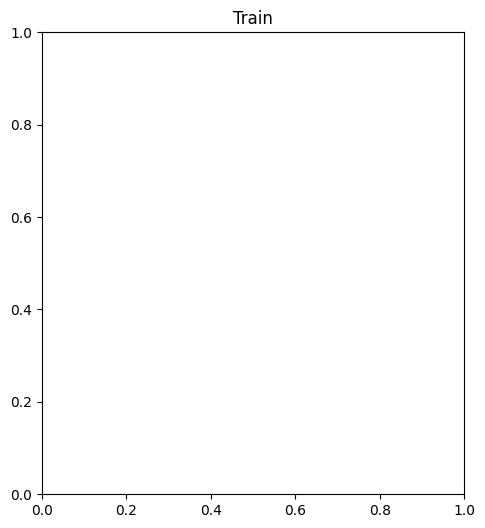

In [63]:
#Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4, X_test,y_test)

In [ ]:
import torchmetrics
from torchmetrics import Accuracy

torch_acc=Accuracy(task='multiclass',num_classes=num_classes).to(device)

torch_acc(y_preds,y_test) #(input, target)
